In [31]:
import os
import yaml
import pandas as pd
import numpy as np
import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display 
pd.options.display.max_columns = None
%matplotlib inline

In [2]:
with open('db_default_profile.yaml') as fd:
    config = yaml.load(fd)
    dburl = sqlalchemy.engine.url.URL(
        "postgres",
        host=config["host"],
        username=config["user"],
        database='johnson_county_ddj',
        password=config["pass"],
        port=config["port"],
    )
    engine_joco = sqlalchemy.create_engine(dburl, poolclass=sqlalchemy.pool.QueuePool)

In [3]:
joco_sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM kit_bias_class_figs.model_adjustment_results_race_2way
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_white_to_nonwhite AS recall_white_to_nonwhite,
       r.base_frac_white AS frac_white,
       r.base_frac_nonwhite AS frac_nonwhite
FROM kit_bias_class_figs.model_adjustment_results_race_2way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_white_to_nonwhite AS recall_white_to_nonwhite,
       r.adj_frac_white AS frac_white,
       r.adj_frac_nonwhite AS frac_nonwhite
FROM kit_bias_class_figs.model_adjustment_results_race_2way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_white_to_nonwhite AS recall_white_to_nonwhite,
       r.adj_frac_white AS frac_white,
       r.adj_frac_nonwhite AS frac_nonwhite
FROM kit_bias_class_figs.model_adjustment_results_race_2way r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_white_to_nonwhite,
      frac_white,
      frac_nonwhite
FROM kit_bias_class_figs.composite_results_race_2way
WHERE train_end_time > past_train_end_time
;
"""

In [6]:
joco_df3 = pd.read_sql(joco_sql, engine_joco)

In [8]:
joco_df3.to_csv('joco_race_2way_bias.csv', index=False)

In [9]:
joco_df3['dataset'] = 'joco'
joco_df3 = joco_df3.rename(
    {'recall_white_to_nonwhite': 'recall_disp', 
     'frac_white': 'frac_grp1', 
     'frac_nonwhite': 'frac_grp2'
    }, axis='columns')

In [16]:
joco_df3['strategy'] = joco_df3['strategy'].map({
    'Best Unadjusted Metric - Unadjusted': 'Unmitigated', 
    'Best Adjusted Metric - Adjusted': 'Mitigated - Single Model', 
    'Composite Model - Adjusted': 'Mitigated - Composite Model',
    'Best Unadjusted Metric - Adjusted': 'Mitigated - Unadj. Model Seln.'
})

In [10]:
joco_df3.columns

Index(['strategy', 'train_end_time', 'past_train_end_time', 'list_size',
       'metric', 'parameter', 'value', 'max_recall_ratio', 'recall_disp',
       'frac_grp1', 'frac_grp2', 'dataset'],
      dtype='object')

In [11]:
sj_exp_df = pd.read_csv('/mnt/data/users/kit/sj/san_jose_housing/triage4/sj_figs_20200531_exp_df.csv')
sj_exp_df['train_end_time'] = pd.to_datetime(sj_exp_df['train_end_time'])
sj_exp_df['strategy'] = sj_exp_df['strategy'].map({
    'Best Unadjusted Metric - Unadjusted': 'Unmitigated', 
    'Best Adjusted Metric - Adjusted': 'Mitigated - Single Model', 
    'Composite Model - Adjusted': 'Mitigated - Composite Model',
    'Best Unadjusted Metric - Adjusted': 'Mitigated - Unadj. Model Seln.'
})

In [27]:
dc_df = pd.read_csv('/mnt/data/users/kit/joco/misc_notebooks/donors_povery_2way_bias.csv')
dc_df = dc_df.rename(
    {'recall_not_highest_to_highest': 'recall_disp', 
     'frac_not_highest': 'frac_grp1', 
     'frac_highest': 'frac_grp2'
    }, axis='columns')
dc_df = dc_df.loc[(dc_df['train_end_time'] >= '2011-07-01') & (dc_df['list_size'] == 1000),]
dc_df['train_end_time'] = pd.to_datetime(dc_df['train_end_time'])
dc_df['dataset'] = 'donors_choose'

In [32]:
mined_df = pd.read_csv('/mnt/data/users/kit/joco/misc_notebooks/ElSal_10K_Overage.csv', sep='\t', index_col=0)

mined_df = mined_df.rename(
    {'recall_1_to_0': 'recall_disp', 
     'frac_1': 'frac_grp1', 
     'frac_0': 'frac_grp2'
    }, axis='columns')

# group fractions are missing?
mined_df['dataset'] = 'el_salvador'
mined_df['frac_grp1'] = np.nan
mined_df['frac_grp2'] = np.nan

mined_df = mined_df[sj_exp_df.columns]

# exclude 2011 datapoint based on selection from 2010 models with no features!
mined_df = mined_df.loc[(mined_df['train_end_time'] > '2011-01-01'),]

mined_df['train_end_time'] = pd.to_datetime(mined_df['train_end_time'])

mined_df['strategy'] = mined_df['strategy'].map({
    'Best Unadjusted Metric - Unadjusted': 'Unmitigated', 
    'Best Adjusted Metric - Adjusted': 'Mitigated - Single Model', 
    'Composite Model - Adjusted': 'Mitigated - Composite Model',
    'Best Unadjusted Metric - Adjusted': 'Mitigated - Unadj. Model Seln.'
})

In [33]:
mined_df.columns

Index(['strategy', 'train_end_time', 'past_train_end_time', 'list_size',
       'metric', 'parameter', 'value', 'max_recall_ratio', 'recall_disp',
       'frac_grp1', 'frac_grp2', 'dataset'],
      dtype='object')

In [34]:
comp_df = pd.concat([joco_df3, sj_exp_df, dc_df, mined_df])

comp_df['dataset'] = comp_df['dataset'].map({
    'donors_choose': 'Education Crowdfunding', 
    'joco': 'Inmate Mental Health', 
    'san_jose': 'Housing Safety',
    'el_salvador': 'Student Outcomes'
})

comp_df = comp_df.sort_values(['dataset'])

comp_df['strategy'].unique()

array(['Unmitigated', 'Mitigated - Unadj. Model Seln.',
       'Mitigated - Single Model', 'Mitigated - Composite Model'],
      dtype=object)

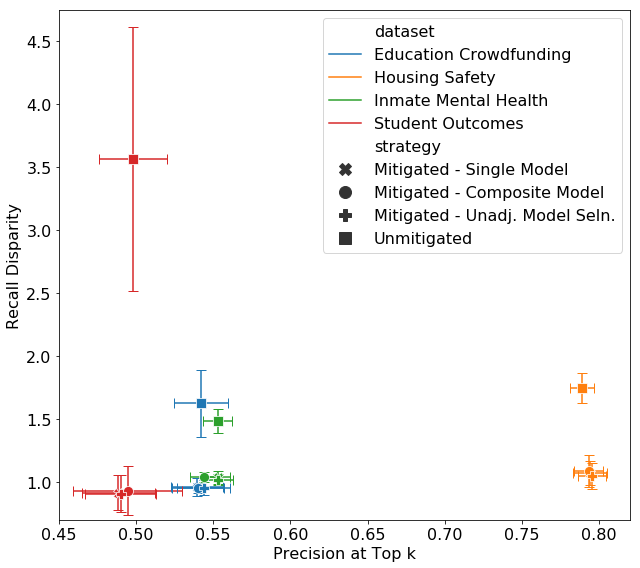

In [35]:
sty_ord = [
    'Mitigated - Single Model', 
    'Mitigated - Composite Model',
    'Mitigated - Unadj. Model Seln.',
    'Unmitigated'
]

fig, ax = plt.subplots(figsize=(9,8))
sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(), 
              x='value', y='recall_disp', 
              hue='dataset', 
#              marker="o", 
              style='strategy',
              style_order=sty_ord,
#              markers=True,
#              markers=['$A1$', '$A2$', '$U$', '$A3$'],
#              markers=['$A1$', '$A2$', cut_star, '$A3$'],
              markers=['X', 'o', 'P', 's'],
#              color='dodgerblue',
              markersize=10,
#               fillstyle='full',
#               markeredgecolor='black',
#               markeredgewidth=1.0,
              dashes=None,
              ci=None,
              ax=ax)


for i, ds in enumerate(comp_df['dataset'].unique()):
    tmp_df = comp_df.loc[comp_df['dataset'] == ds, ].copy()
    
    x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)

    prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
    colors = sns.color_palette().as_hex()[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
        ecolor=colors, 
        fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.45,0.82))
ax.set_ylim((0.7,4.75))

ax.set_ylabel('Recall Disparity', fontsize=16)
ax.set_xlabel('Precision at Top k', fontsize=16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)


handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in list(comp_df['dataset'].unique()) + ['dataset', 'strategy']:
        handles[i].set_linestyle("")
    hhandles.append(handles[i])
    llabels.append(lab)
# ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
ax.legend(hhandles, llabels, fontsize=16, markerscale=2)

# ax.plot((0,1),(1,1),'k-', zorder=0)

fig.tight_layout()

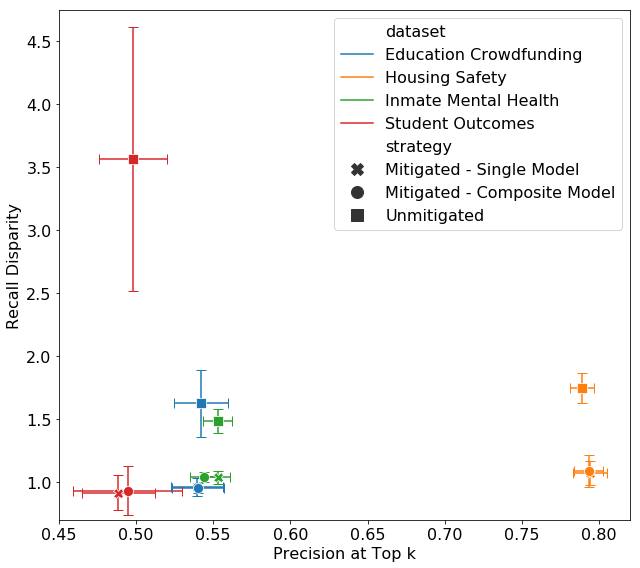

In [36]:
sty_ord = [
    'Mitigated - Single Model', 
    'Mitigated - Composite Model',
    'Unmitigated'
]

fig, ax = plt.subplots(figsize=(9,8))
sns.lineplot(data=comp_df.loc[comp_df['strategy'] != 'Mitigated - Unadj. Model Seln.', ].groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(), 
              x='value', y='recall_disp', 
              hue='dataset', 
#              marker="o", 
              style='strategy',
              style_order=sty_ord,
#              markers=True,
#              markers=['$A1$', '$A2$', '$U$', '$A3$'],
#              markers=['$A1$', '$A2$', cut_star, '$A3$'],
              markers=['X', 'o', 's'],
#              color='dodgerblue',
              markersize=10,
#               fillstyle='full',
#               markeredgecolor='black',
#               markeredgewidth=1.0,
              dashes=None,
              ci=None,
              ax=ax)


for i, ds in enumerate(comp_df['dataset'].unique()):
    tmp_df = comp_df.loc[(comp_df['dataset'] == ds) & (comp_df['strategy'] != 'Mitigated - Unadj. Model Seln.'), ].copy()
    
    x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)

    prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
    colors = sns.color_palette().as_hex()[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
        ecolor=colors, 
        fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.45,0.82))
ax.set_ylim((0.7,4.75))

ax.set_ylabel('Recall Disparity', fontsize=16)
ax.set_xlabel('Precision at Top k', fontsize=16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)


handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in list(comp_df['dataset'].unique()) + ['dataset', 'strategy']:
        handles[i].set_linestyle("")
    hhandles.append(handles[i])
    llabels.append(lab)
# ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
ax.legend(hhandles, llabels, fontsize=16, markerscale=2)

# ax.plot((0,1),(1,1),'k-', zorder=0)

fig.tight_layout()

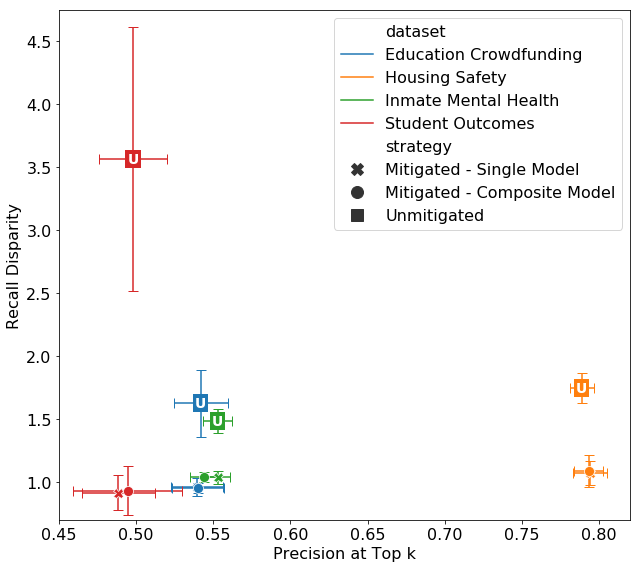

In [80]:
# Experimenting with adding the "U" characters via matplotlib rather than afterwards -- it still looks a little
# off and would need to find the right location for the one in the legend through trial and error, but this
# might be a decent option if we need a higher-resoluation image for publication?


sty_ord = [
    'Mitigated - Single Model', 
    'Mitigated - Composite Model',
    'Unmitigated'
]

fig, ax = plt.subplots(figsize=(9,8))
sns.lineplot(data=comp_df.loc[comp_df['strategy'] != 'Mitigated - Unadj. Model Seln.', ].groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(), 
              x='value', y='recall_disp', 
              hue='dataset', 
#              marker="o", 
              style='strategy',
              style_order=sty_ord,
#              markers=True,
#              markers=['$A1$', '$A2$', '$U$', '$A3$'],
#              markers=['$A1$', '$A2$', cut_star, '$A3$'],
              markers=['X', 'o', 's'],
#              color='dodgerblue',
              markersize=10,
#               fillstyle='full',
#               markeredgecolor='black',
#               markeredgewidth=1.0,
              dashes=None,
              ci=None,
              ax=ax)


for i, ds in enumerate(comp_df['dataset'].unique()):
    tmp_df = comp_df.loc[(comp_df['dataset'] == ds) & (comp_df['strategy'] != 'Mitigated - Unadj. Model Seln.'), ].copy()
    
    x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)

    prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
    colors = sns.color_palette().as_hex()[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
        ecolor=colors, 
        fmt=' ', zorder=-1, capsize=5)

    x_unmitigated = tmp_df.loc[(tmp_df['strategy'] == 'Unmitigated'), ].groupby('dataset')['value'].mean().reset_index()['value'].values
    y_unmitigated = tmp_df.loc[(tmp_df['strategy'] == 'Unmitigated'), ].groupby('dataset')['recall_disp'].mean().reset_index()['recall_disp'].values
    ax.text(x_unmitigated, y_unmitigated, 'U', fontsize=14, color='white', 
        ha='center', va='center', weight='black',
        bbox=dict(facecolor=colors, edgecolor='none', pad=2))

ax.set_xlim((0.45,0.82))
ax.set_ylim((0.7,4.75))

ax.set_ylabel('Recall Disparity', fontsize=16)
ax.set_xlabel('Precision at Top k', fontsize=16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in list(comp_df['dataset'].unique()) + ['dataset', 'strategy']:
        handles[i].set_linestyle("")
    hhandles.append(handles[i])
    llabels.append(lab)
# ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
ax.legend(hhandles, llabels, fontsize=16, markerscale=2)

# ax.plot((0,1),(1,1),'k-', zorder=0)

fig.tight_layout()

In [45]:
comp_df.loc[(comp_df['strategy'] == 'Unmitigated'), ].groupby('dataset').mean()

,list_size,value,max_recall_ratio,recall_disp,frac_grp1,frac_grp2
dataset,,,,,,
Education Crowdfunding,1000,0.542000,1.624607,1.624607,0.606100,0.393900
Housing Safety,500,0.788578,1.744514,1.744514,0.633714,0.366286
Inmate Mental Health,500,0.553068,1.486855,1.486855,0.709765,0.290000
Student Outcomes,10000,0.498122,3.566395,3.566395,NaN,NaN


In [114]:
from scipy.stats import ttest_ind

In [84]:
df_orig = comp_df.loc[(comp_df['dataset'] == 'Housing Safety') & (comp_df['strategy'] == 'Unmitigated'), ['value']]
df_corr = comp_df.loc[(comp_df['dataset'] == 'Housing Safety') & (comp_df['strategy'] == 'Mitigated - Single Model'), ['value']]

In [85]:
ttest_ind(df_orig['value'], df_corr['value'])

Ttest_indResult(statistic=-0.8005879229486914, pvalue=0.43062543663176145)

In [116]:
# 2-sided t-test for the unmitigated vs mitigated - single model precisions

for i, ds in enumerate(comp_df['dataset'].unique()):
    print(ds)
    df_orig = comp_df.loc[(comp_df['dataset'] == ds) & (comp_df['strategy'] == 'Unmitigated'), ['train_end_time', 'value']].sort_values('train_end_time').groupby('train_end_time')['value'].mean().to_frame()
    df_corr = comp_df.loc[(comp_df['dataset'] == ds) & (comp_df['strategy'] == 'Mitigated - Single Model'), ['train_end_time', 'value']].sort_values('train_end_time').groupby('train_end_time')['value'].mean().to_frame()
    print(ttest_ind(df_orig['value'], df_corr['value']))


Education Crowdfunding
Ttest_indResult(statistic=0.21710200848563305, pvalue=0.8305706302833114)
Housing Safety
Ttest_indResult(statistic=-0.7364126687269733, pvalue=0.4721396326511358)
Inmate Mental Health
Ttest_indResult(statistic=0.20745153049357476, pvalue=0.8379861699357891)
Student Outcomes
Ttest_indResult(statistic=0.38426703004692686, pvalue=0.710793190268381)


In [117]:
# 2-sided t-test for the unmitigated vs mitigated - composite precisions

for i, ds in enumerate(comp_df['dataset'].unique()):
    print(ds)
    df_orig = comp_df.loc[(comp_df['dataset'] == ds) & (comp_df['strategy'] == 'Unmitigated'), ['train_end_time', 'value']].sort_values('train_end_time').groupby('train_end_time')['value'].mean().to_frame()
    df_corr = comp_df.loc[(comp_df['dataset'] == ds) & (comp_df['strategy'] == 'Mitigated - Composite Model'), ['train_end_time', 'value']].sort_values('train_end_time').groupby('train_end_time')['value'].mean().to_frame()
    print(ttest_ind(df_orig['value'], df_corr['value']))

Education Crowdfunding
Ttest_indResult(statistic=0.152969017589323, pvalue=0.8801244566281576)
Housing Safety
Ttest_indResult(statistic=-0.535639242339626, pvalue=0.5995752521137514)
Inmate Mental Health
Ttest_indResult(statistic=1.3665716092375249, pvalue=0.18858842167810227)
Student Outcomes
Ttest_indResult(statistic=0.3624135481137994, pvalue=0.7264303986179541)


In [118]:
comp_df.loc[(comp_df['strategy'] == 'Unmitigated'), ['dataset', 'value']].groupby('dataset').mean()

,value
dataset,
Education Crowdfunding,0.542000
Housing Safety,0.788578
Inmate Mental Health,0.553068
Student Outcomes,0.498122


In [122]:
comp_df.loc[(comp_df['strategy'] == 'Mitigated - Composite Model'), ['dataset', 'value']].groupby('dataset').mean()

,value
dataset,
Education Crowdfunding,0.540100
Housing Safety,0.793207
Inmate Mental Health,0.543800
Student Outcomes,0.494620
